### Try-it 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models.  You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model.  In addition to the prior strategies, this example is an excellent opportunity to utilize the `TransformedTargetRegressor` estimator in scikitlearn.

### The Data

This dataset is loaded from the openml resource library.  Originally from census data, the data contains wage and demographic information on 534 individuals. From the dataset documentation [here](https://www.openml.org/d/534)

```
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. 
```

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
wages = fetch_openml(data_id=534, as_frame=True)

#### Task

Build regression models to predict `WAGE`.  Incorporate the categorical features and transform the target using a logarithm.  Build `Ridge` models and consider some different amounts of regularization.  

After fitting your model, interpret the model and try to understand what features led to higher wages.  Consider using `permutation_importance` that you encountered in module 8.  Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients see the example in scikitlearn examples [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np
import plotly.express as px
import pandas as pd
import warnings

In [97]:
wages.frame.shape

(534, 11)

In [96]:
wages.frame.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


In [142]:
df = wages.frame.copy()

X = df.drop('WAGE', axis = 1)
y = df['WAGE']

categorical_columns = [i for i in X.select_dtypes(include=['category']).columns]
numerical_columns = [i for i in X.columns if i not in categorical_columns]

column_transformer = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (PolynomialFeatures(include_bias = False, degree = 1), numerical_columns),
    remainder='passthrough', verbose_feature_names_out=False
).fit(X)

X_transformed = pd.DataFrame(column_transformer.fit_transform(X), columns = column_transformer.get_feature_names_out())

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=100))
])

model = TransformedTargetRegressor(regressor = pipeline, func = np.log, inverse_func = np.exp)

# param_grid = {
#     'regressor__model__alpha': 10**np.arange(-5, 10, dtype=float)
# }
# search_cv = GridSearchCV(estimator = model, param_grid = param_grid, cv=5, verbose = 1)
# search_cv.fit(X_transformed, y)
# best_estimator = search_cv.best_estimator_

In [143]:
cv = KFold(n_splits=15, shuffle=True, random_state=0)
scores = cross_val_score(model, X_transformed, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores = np.abs(scores)
s_mean = np.mean(scores)

print(s_mean)
print(scores)

19.74072090089211
[23.6026635  15.80019035  8.46543157 22.31530934 17.90727619 56.66281606
 16.2416308  13.66608258 17.82939875 16.5165968  31.56831536 11.29961147
 15.45644063 12.25596028 16.52308985]


In [144]:
model.fit(X_transformed, y)


TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('scaler',
                                                      StandardScaler()),
                                                     ('model',
                                                      Ridge(alpha=100))]))

In [145]:
model_coefs = pd.DataFrame([model.regressor_.named_steps['model'].coef_.T], columns=model.regressor_[:-1].get_feature_names_out(), index = ['coeffs'])

In [146]:
model_coefs

,SOUTH_no,SOUTH_yes,SEX_female,SEX_male,UNION_member,UNION_not_member,RACE_Hispanic,RACE_Other,RACE_White,OCCUPATION_Clerical,...,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Construction,SECTOR_Manufacturing,SECTOR_Other,MARR_Married,MARR_Unmarried,EDUCATION,EXPERIENCE,AGE
coeffs,0.021761,-0.021761,-0.049155,0.049155,0.038249,-0.038249,-0.016073,-0.00959,0.017588,-0.003751,...,-0.033937,-0.060222,0.006491,0.019336,-0.021041,0.015299,-0.015299,0.129755,0.032703,0.062628


In [147]:
r = permutation_importance(model, X_transformed, y, n_repeats=30, random_state=0)

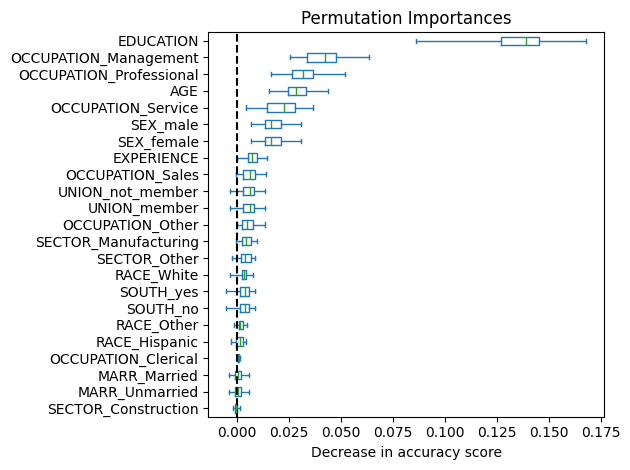

In [150]:
sorted_importances_idx = r.importances_mean.argsort()
importances = pd.DataFrame(
    r.importances[sorted_importances_idx].T,
    columns=X_transformed.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{pipelines[1].named_steps['transformer'].feature_names_in_[i]:<8}: "
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")
        
